<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/WOOK/Distilbert_base_1_N(MSR%2Bjulite%2BDiv_final_csv)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install shap
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

import pandas as pd
import re
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# CSV 파일 로드
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cwe file/MSR+julite+Div_final.csv')

# 데이터 전처리 함수
def preprocess(df):
    df['code'] = df['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#endif'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n\s*\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return*.*?;'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return;'), "", regex=True)
    return df

# 데이터 전처리
df = preprocess(df)
df.to_csv("preprocessed_data.csv", index=False)

# 데이터셋 로드 및 토큰화 함수 정의
def tokenized(examples):
    return tokenizer(examples['code'], padding='max_length', max_length=512, truncation=True, return_token_type_ids=True)

# 데이터셋 로드
dataset = load_dataset("csv", data_files="preprocessed_data.csv")['train']
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
encoded_dataset = dataset.map(tokenized, remove_columns=['code'], batched=True)
encoded_dataset = encoded_dataset.train_test_split(0.3, seed=100)

# 모델 로드
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(df['CWE ID'].unique()))

# 컴퓨트 메트릭스 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_per_class = f1_score(labels, predictions, average=None)
    f1_weighted = f1_score(labels, predictions, average='weighted')
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    recall_weighted = recall_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    metrics = {
        'accuracy': accuracy,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    }

    for i, f1 in enumerate(f1_per_class):
        metrics[f'f1_class_{i}'] = f1

    return metrics

# TrainingArguments 정의
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

# 트레이너 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics,
)

# 모델 학습
trainer.train()



Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15838 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8,F1 Class 9
500,2.013900,1.816949,0.351852,0.351852,0.288201,0.226323,0.351852,0.578361,0.366549,0.322398,0.000000,0.000000,0.878173,0.100000,0.017751,0.000000,0.000000
1000,1.573300,1.357084,0.554082,0.554082,0.533304,0.488365,0.554082,0.758974,0.526861,0.418562,0.501176,0.505017,0.932836,0.353488,0.416382,0.021898,0.448454
1500,1.183900,1.191423,0.617003,0.617003,0.607556,0.576029,0.617003,0.793527,0.592411,0.525794,0.554007,0.569260,0.901542,0.562197,0.452282,0.310263,0.499010
2000,0.886500,1.067760,0.673611,0.673611,0.668398,0.648881,0.673611,0.801539,0.637037,0.572000,0.653887,0.651817,0.928830,0.596439,0.575862,0.475375,0.596026
2500,0.597400,1.065999,0.699495,0.699495,0.696734,0.682365,0.699495,0.821591,0.649521,0.623853,0.649805,0.698980,0.926417,0.671378,0.601770,0.572043,0.608295
3000,0.449200,1.064399,0.713384,0.713384,0.713733,0.698588,0.713384,0.839582,0.675947,0.641543,0.676953,0.701956,0.933333,0.672158,0.610169,0.572477,0.661765


TrainOutput(global_step=3465, training_loss=1.011897081867785, metrics={'train_runtime': 797.9489, 'train_samples_per_second': 69.466, 'train_steps_per_second': 4.342, 'total_flos': 7343715475968000.0, 'train_loss': 1.011897081867785, 'epoch': 5.0})

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


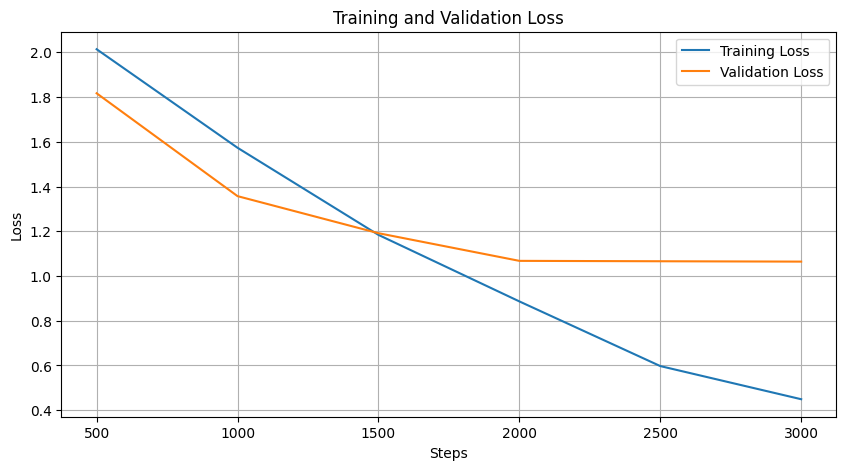

In [4]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

def plot_training_loss(log_dir):
    event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events' in f]
    if not event_files:
        raise ValueError("No event files found in log directory.")

    for event_file in event_files:
        losses = {'Step': [], 'Training Loss': [], 'Validation Loss': []}
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.tag == 'train/loss':
                    losses['Training Loss'].append(v.simple_value)
                    losses['Step'].append(e.step)
                elif v.tag == 'eval/loss':
                    losses['Validation Loss'].append(v.simple_value)

        if losses['Step']:
            df = pd.DataFrame(losses).set_index('Step')
            plt.figure(figsize=(10, 5))
            plt.plot(df['Training Loss'], label='Training Loss')
            plt.plot(df['Validation Loss'], label='Validation Loss')
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# 로그 디렉토리를 지정하여 그래프 그리기
plot_training_loss('./logs')